In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

# **Preprocessing the Data**

In [2]:
df = pd.read_csv("/content/fifa_players.csv")

In [3]:
def preprocess_data(df, target_player_name):
    # Features used for similarity comparison
    features_for_knn = [
        'overall_rating', 'finishing', 'dribbling', 'short_passing',
        'vision', 'positioning', 'composure',
        'ball_control', 'skill_moves(1-5)', 'sprint_speed', 'acceleration',
        'interceptions', 'sliding_tackle'
    ]

    # Extra metadata columns to keep
    extra_features = ['value_euro', 'name', 'positions', 'age', 'potential']

    # Keep only relevant columns and drop rows with missing values
    df = df[features_for_knn + extra_features].dropna()

    # Select the row corresponding to the target player
    target_player = df[df['name'] == target_player_name].iloc[0]

    # Filter dataset: keep players less valuable and younger than the target
    filtered_df = df[
        (df['value_euro'] < target_player['value_euro']) &
        (df['age'] < target_player['age'])
    ].copy()

    # Save an unscaled version for reference or visualization
    filtered_df_unscaled = filtered_df.copy()

    # Normalize the features
    scaler = StandardScaler()
    filtered_df[features_for_knn] = scaler.fit_transform(filtered_df[features_for_knn])

    # Normalize the target player features using the same scaler
    target_player[features_for_knn] = scaler.transform(
        target_player[features_for_knn].values.reshape(1, -1)
    )[0]

    return filtered_df, target_player, filtered_df_unscaled

# **kNN application**

In [4]:
def find_similar_players(filtered_df_scaled, filtered_df_unscaled, target_player_scaled, k=1000, metric='euclidean'):
    # Fit Nearest Neighbors on scaled data (excluding non-numeric metadata columns)
    model = NearestNeighbors(n_neighbors=k, metric=metric)
    model.fit(filtered_df_scaled.drop(columns=['name', 'value_euro', 'positions', 'age', 'potential'], errors='ignore'))

    # Find k nearest neighbors to the scaled target player
    distances, indices = model.kneighbors(
        target_player_scaled.drop(labels=['name', 'value_euro', 'positions', 'age', 'potential'], errors='ignore')
        .values.reshape(1, -1)
    )
    # Retrieve the corresponding unscaled player rows and add distance as a column
    similar_players = filtered_df_unscaled.iloc[indices[0]].copy()
    similar_players['distance'] = distances[0]
    return similar_players


# **k-Means Clustering**

In [5]:
def kmeans_cluster_players(df_scaled, num_clusters=5):
    # Initialize and fit k-Means model on feature columns (excluding metadata)
    model = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = model.fit_predict(
        df_scaled.drop(columns=['name', 'value_euro', 'positions', 'age', 'potential'], errors='ignore')
    )

    return cluster_labels, model

# **HDBSCAN Clustering**

In [6]:
def hdbscan_cluster_players(df_scaled, min_cluster_size=3, min_samples=1):
    # Extract only numerical features for clustering
    data = df_scaled.drop(columns=['name', 'value_euro', 'positions', 'age', 'potential'], errors='ignore')

    # Apply HDBSCAN clustering
    model = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
    cluster_labels = model.fit_predict(data)

    return cluster_labels, model

# **Plotting**

In [7]:
def plot_similar_players(similar_players, target_player_name):
    """
    Plots the distances of players most similar to the target player.

    Parameters:
    - similar_players (pd.DataFrame): DataFrame containing similar players and their distances
    - target_player_name (str): Name of the target player (for plot title)
    """

    # Set up the plot
    plt.figure(figsize=(10, 6))
    sns.barplot(x='name', y='distance', data=similar_players)

    # Labeling and formatting
    plt.title(f'Similar Players to {target_player_name}')
    plt.xlabel('Player Name')
    plt.ylabel('Distance')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    # Display the plot
    plt.show()


# **Main**

In [8]:
# Set your target player
target_player_name = 'M. Lewandowski'
# Preprocess
filtered_df_scaled, target_player_scaled, filtered_df_unscaled = preprocess_data(df, target_player_name)

Target Player: M. Lewandowski Information


,name,age,overall_rating,potential,positions,value_euro
8470,M. Lewandowski,25,62,63,LB,290000.0


Top 10 Most Similar Players BEFORE Clustering:


,name,distance,age,overall_rating,potential,positions,value_euro
3801,K. Partida,1.28,23,61,66,"LB,CM",280000.0
7316,B. Halliday,1.29,23,60,65,RB,230000.0
4050,L. Sutton,1.30,21,60,68,"RB,CM",260000.0
7342,D. Rasak,1.38,23,60,66,CDM,240000.0
3913,C. Martin,1.42,24,61,65,"CDM,CM",280000.0
4094,E. Henschel,1.44,22,59,69,"RM,RB",250000.0
7524,S. Griffin,1.49,24,61,66,LB,280000.0
4027,A. Hollingen,1.51,24,60,64,CM,270000.0
6906,C. Kablan,1.53,24,59,65,"LB,RB",180000.0
3946,D. Cruz,1.53,24,60,65,"RB,LB,RWB,LWB",230000.0


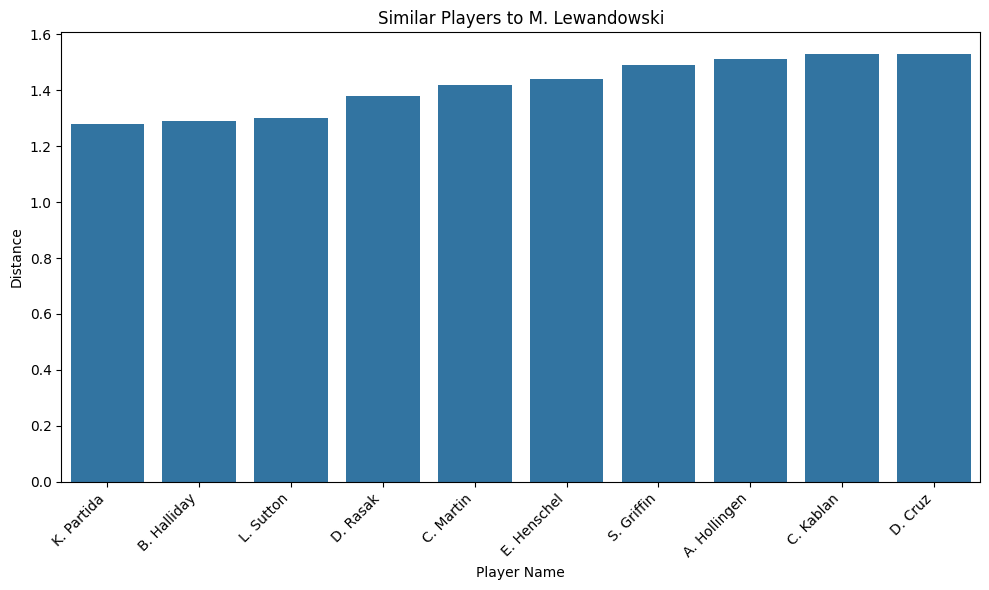

In [9]:
## kNN
# Correct unscaled combination
target_player_unscaled = df[df['name'] == target_player_name][[
      'overall_rating', 'finishing', 'dribbling', 'short_passing',
      'vision', 'positioning', 'composure',
      'ball_control', 'skill_moves(1-5)', 'sprint_speed', 'acceleration',
      'interceptions', 'sliding_tackle',
      'name', 'age', 'potential', 'positions', 'value_euro'
]].dropna().iloc[0]
# Find Top 50 Similar Players
similar_players = find_similar_players(filtered_df_scaled, filtered_df_unscaled, target_player_scaled, k=1300, metric='euclidean')
# Get Top 5 purely based on distance
pure_knn_top10 = similar_players.sort_values('distance').head(10)
pure_knn_top10['distance'] = pure_knn_top10['distance'].round(2)
# Display
print(f"Target Player: {target_player_name} Information")
display(target_player_unscaled[['name', 'age', 'overall_rating', 'potential', 'positions', 'value_euro']].to_frame().T)
print("Top 10 Most Similar Players BEFORE Clustering:")
display(pure_knn_top10[['name', 'distance', 'age', 'overall_rating', 'potential', 'positions', 'value_euro']])
# Plot
plot_similar_players(pure_knn_top10, target_player_name)

Target Player: M. Lewandowski Information


,name,age,overall_rating,potential,positions,value_euro
8470,M. Lewandowski,25,62,63,LB,290000.0


Top 5 Most Similar Players AFTER Clustering (Same Play Style):


,name,distance,age,overall_rating,potential,positions,value_euro
3801,K. Partida,1.28,23,61,66,"LB,CM",280000.0
7316,B. Halliday,1.29,23,60,65,RB,230000.0
4050,L. Sutton,1.30,21,60,68,"RB,CM",260000.0
7342,D. Rasak,1.38,23,60,66,CDM,240000.0
3913,C. Martin,1.42,24,61,65,"CDM,CM",280000.0
4094,E. Henschel,1.44,22,59,69,"RM,RB",250000.0
7524,S. Griffin,1.49,24,61,66,LB,280000.0
4027,A. Hollingen,1.51,24,60,64,CM,270000.0
6906,C. Kablan,1.53,24,59,65,"LB,RB",180000.0
3946,D. Cruz,1.53,24,60,65,"RB,LB,RWB,LWB",230000.0


Silhouette Score: 0.212


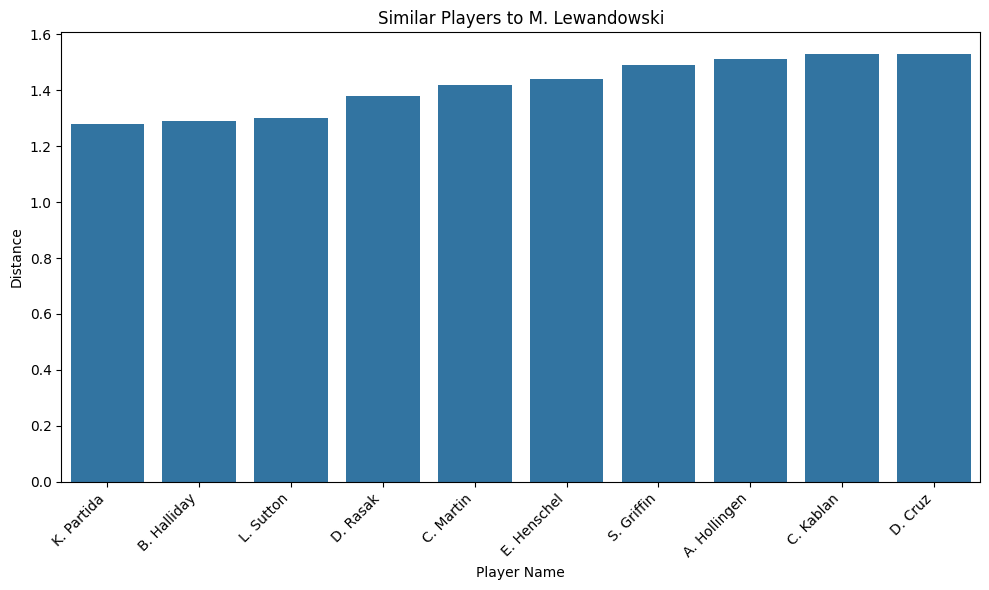

In [10]:
# k-Means
# Prepare combined scaled data
target_df = pd.DataFrame([target_player_scaled.drop(labels='name', errors='ignore')], columns=filtered_df_scaled.columns.drop('name'))
combined_scaled = pd.concat([filtered_df_scaled.loc[similar_players.index], target_df], axis=0)
# Cluster
cluster_labels, model = kmeans_cluster_players(combined_scaled, num_clusters=5)
# Find target's cluster
target_cluster_label = cluster_labels[-1]
# Filter same-cluster players
similar_players['cluster'] = cluster_labels[:-1]
same_cluster_players = similar_players[similar_players['cluster'] == target_cluster_label]

# Get Top 10 closest among same-cluster players
same_cluster_top10 = same_cluster_players.sort_values('distance').head(10)
# Decode for display
same_cluster_top10['distance'] = same_cluster_top10['distance'].round(2)
# Display
print(f"Target Player: {target_player_name} Information")
display(target_player_unscaled[['name', 'age', 'overall_rating', 'potential', 'positions', 'value_euro']].to_frame().T)
print("Top 5 Most Similar Players AFTER Clustering (Same Play Style):")
display(same_cluster_top10[['name', 'distance', 'age', 'overall_rating', 'potential', 'positions', 'value_euro']])

# Clustering score:
score = silhouette_score(
    combined_scaled.drop(columns=['name', 'value_euro', 'positions', 'age', 'potential'], errors='ignore'),
    cluster_labels
)
print(f"Silhouette Score: {score:.3f}")
# Plot
plot_similar_players(same_cluster_top10, target_player_name)

Top features contributing to PC1:
interceptions     0.507656
sliding_tackle    0.470770
finishing        -0.440111
vision           -0.362618
composure        -0.259276
Name: PC1, dtype: float64

Top features contributing to PC2:
composure         0.512729
vision            0.458009
short_passing     0.380958
sliding_tackle    0.342820
interceptions     0.298805
Name: PC2, dtype: float64


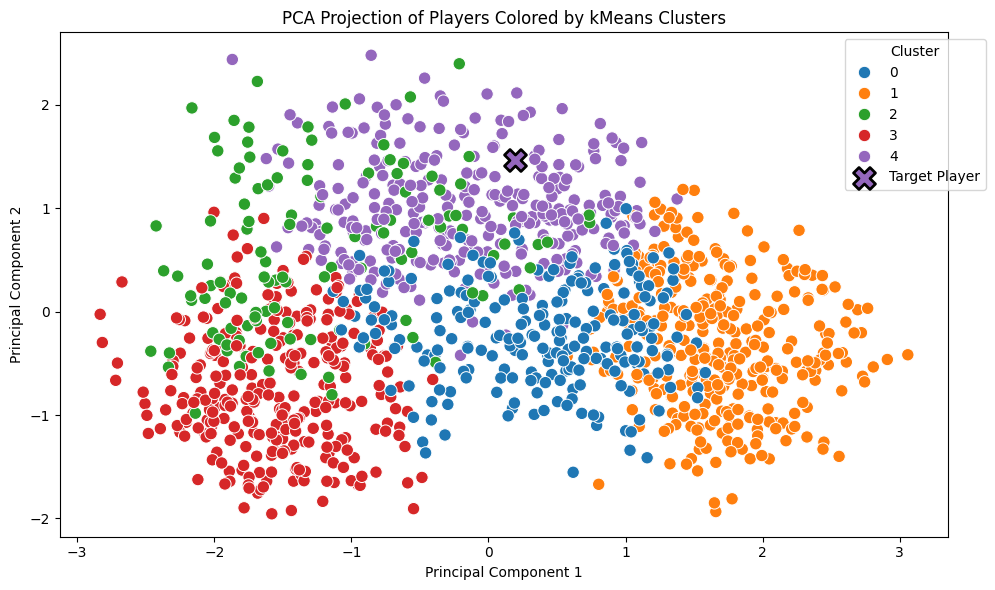

In [11]:
X = combined_scaled.drop(columns=['name', 'value_euro', 'positions', 'age', 'potential'], errors='ignore')

# 2. Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# 3. View principal component loadings
features = X.columns
loadings = pd.DataFrame(
    pca.components_.T,  # transpose so rows = features
    columns=['PC1', 'PC2'],
    index=features
)

# 4. Sort and show top features for PC1 and PC2
pc1_sorted = loadings['PC1'].abs().sort_values(ascending=False)
pc2_sorted = loadings['PC2'].abs().sort_values(ascending=False)

print("Top features contributing to PC1:")
print(loadings.loc[pc1_sorted.index[:5], 'PC1'])

print("\nTop features contributing to PC2:")
print(loadings.loc[pc2_sorted.index[:5], 'PC2'])

# 5. Create a DataFrame for plotting
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

# 6. Set up color palette
palette = sns.color_palette('tab10', n_colors=len(pca_df['Cluster'].unique()))

# 7. Plot
plt.figure(figsize=(10,6))

# Plot all players except target
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    data=pca_df.iloc[:-1],  # exclude target player for coloring
    palette=palette,
    s=80,
    legend='full'
)

# Find target player's cluster label
target_cluster = pca_df.iloc[-1]['Cluster']

# Find matching color for the target player
target_color = palette[int(target_cluster)]

# Plot target player separately
plt.scatter(
    pca_df.iloc[-1]['PC1'],
    pca_df.iloc[-1]['PC2'],
    color=target_color,
    marker='X',
    s=250,
    edgecolor='black',
    linewidth=2,
    label='Target Player'
)

# 8. Plot settings
plt.title('PCA Projection of Players Colored by kMeans Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

Target Player: M. Lewandowski Information


,name,age,overall_rating,potential,positions,value_euro
8470,M. Lewandowski,25,62,63,LB,290000.0


Top 5 Most Similar Players AFTER  Density-based Clustering (Same Play Style):


,name,distance,age,overall_rating,potential,positions,value_euro
3801,K. Partida,1.28,23,61,66,"LB,CM",280000.0
7316,B. Halliday,1.29,23,60,65,RB,230000.0
4050,L. Sutton,1.30,21,60,68,"RB,CM",260000.0
7342,D. Rasak,1.38,23,60,66,CDM,240000.0
3913,C. Martin,1.42,24,61,65,"CDM,CM",280000.0
4094,E. Henschel,1.44,22,59,69,"RM,RB",250000.0
7524,S. Griffin,1.49,24,61,66,LB,280000.0
4027,A. Hollingen,1.51,24,60,64,CM,270000.0
6906,C. Kablan,1.53,24,59,65,"LB,RB",180000.0
3946,D. Cruz,1.53,24,60,65,"RB,LB,RWB,LWB",230000.0


Silhouette Score: 0.161


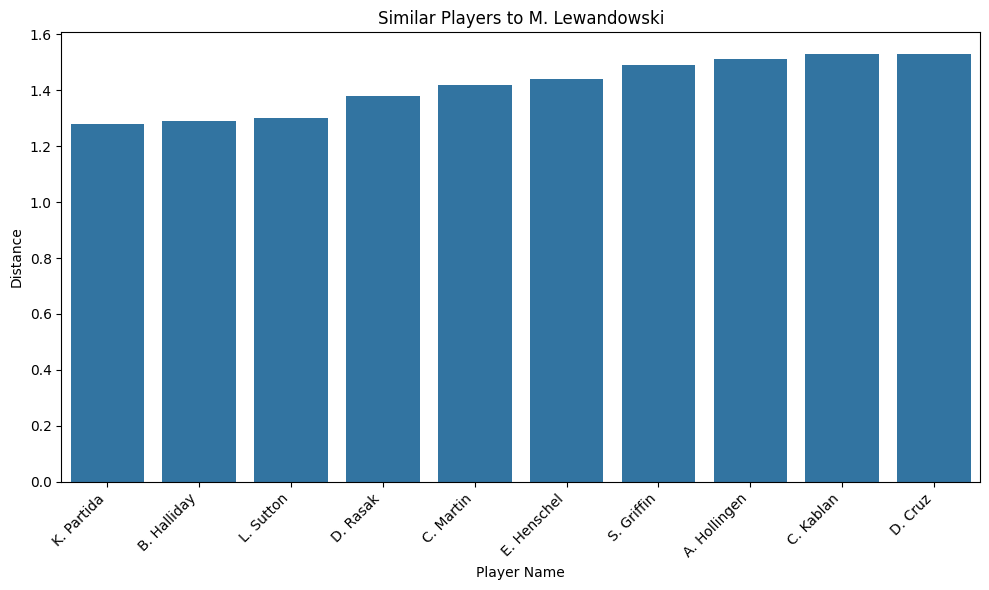

In [12]:
# HDBSCAN

similar_players = find_similar_players(
    filtered_df_scaled,
    filtered_df_unscaled,
    target_player_scaled,
    k=1300,
    metric='euclidean'
)

# Prepare combined scaled data
target_df = pd.DataFrame(
    [target_player_scaled.drop(labels='name', errors='ignore')],
    columns=filtered_df_scaled.columns.drop('name')
)
combined_scaled = pd.concat([filtered_df_scaled.loc[similar_players.index], target_df], axis=0)

# Clean feature matrix for clustering and silhouette score
X = combined_scaled.drop(columns=['name', 'value_euro', 'positions', 'age', 'potential'], errors='ignore')

# Cluster using HDBSCAN
model = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2)
cluster_labels = model.fit_predict(X)

# Find target's cluster (last row in combined_scaled)
target_cluster_label = cluster_labels[-1]

# Display target player info
print(f"Target Player: {target_player_name} Information")
display(target_player_unscaled[['name', 'age', 'overall_rating', 'potential', 'positions', 'value_euro']].to_frame().T)

# Check if target player is labeled as noise
if target_cluster_label == -1:
    print("⚠️ The target player was labeled as noise and does not belong to any cluster.")
    same_cluster_top5 = pd.DataFrame()
    # Calculate and display silhouette score using cleaned features
    score = silhouette_score(X, cluster_labels)
    print(f"Silhouette Score: {score:.3f}")
else:
    # Assign cluster labels to similar players (excluding the target)
    similar_players = similar_players.copy()
    similar_players['cluster'] = cluster_labels[:-1]

    # Filter players in the same cluster as the target
    same_cluster_players = similar_players[similar_players['cluster'] == target_cluster_label]

    if same_cluster_players.empty:
        print("⚠️ No other players found in the same cluster as the target player.")
        same_cluster_top5 = pd.DataFrame()
    else:
        # Get Top 5 closest among same-cluster players
        same_cluster_top10 = same_cluster_players.sort_values('distance').head(10)
        same_cluster_top10['distance'] = same_cluster_top10['distance'].round(2)

        # Display similar players
        print("Top 5 Most Similar Players AFTER  Density-based Clustering (Same Play Style):")
        display(same_cluster_top10[['name', 'distance', 'age', 'overall_rating', 'potential', 'positions', 'value_euro']])

        # Calculate and display silhouette score using cleaned features
        score = silhouette_score(X, cluster_labels)
        print(f"Silhouette Score: {score:.3f}")

        # Plot
        plot_similar_players(same_cluster_top10, target_player_name)


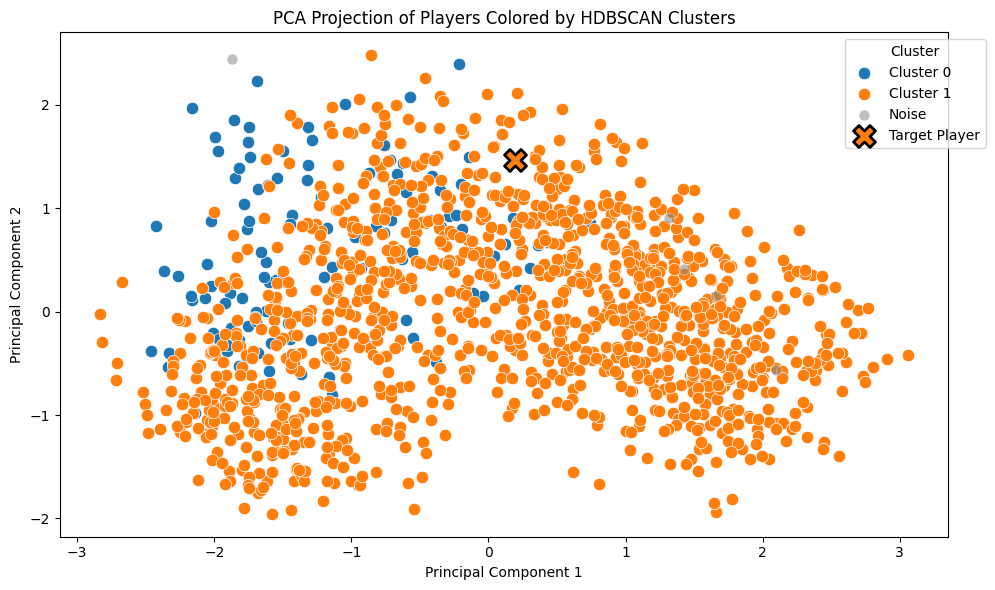

In [13]:
# 1. Drop non-feature columns
X = combined_scaled.drop(columns=['name', 'value_euro', 'positions', 'age', 'potential'], errors='ignore')

# 2. Run PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)

# 3. Create PCA DataFrame
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['Cluster'] = cluster_labels

# 4. Identify valid clusters (exclude -1)
valid_clusters = sorted([c for c in pca_df['Cluster'].unique() if c != -1])
palette = sns.color_palette('tab10', n_colors=len(valid_clusters))
cluster_color_map = {cluster: color for cluster, color in zip(valid_clusters, palette)}

# 5. Assign colors (gray for noise)
pca_df['Color'] = pca_df['Cluster'].map(cluster_color_map).fillna('gray')

# 6. Set up plot
plt.figure(figsize=(10, 6))

# 7. Plot clustered points with white borders
for cluster_val in valid_clusters:
    cluster_points = pca_df.iloc[:-1][pca_df.iloc[:-1]['Cluster'] == cluster_val]
    plt.scatter(
        cluster_points['PC1'], cluster_points['PC2'],
        color=cluster_color_map[cluster_val], s=80,
        edgecolor='white', linewidth=0.5,
        label=f'Cluster {cluster_val}'
    )

# 8. Plot noise points (excluding target)
noise_points = pca_df.iloc[:-1][pca_df.iloc[:-1]['Cluster'] == -1]
if not noise_points.empty:
    plt.scatter(
        noise_points['PC1'], noise_points['PC2'],
        color='gray', s=60, alpha=0.5,
        edgecolor='white', linewidth=0.5,
        label='Noise'
    )

# 9. Plot the target player (always the last row)
target_row = pca_df.iloc[-1]
target_cluster = target_row['Cluster']
target_color = 'gray' if target_cluster == -1 else cluster_color_map[target_cluster]

plt.scatter(
    target_row['PC1'], target_row['PC2'],
    color=target_color, marker='X', s=250,
    edgecolor='black', linewidth=2,
    label='Target Player'
)

# 10. Final plot formatting
plt.title('PCA Projection of Players Colored by HDBSCAN Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


In [14]:
def evaluate_clustering_methods(combined_scaled_df, target_player_scaled):
    """
    Compares k-Means and HDBSCAN clustering methods using silhouette scores.
    Assumes combined_scaled_df includes the target player as the last row.

    Parameters:
    - combined_scaled_df (pd.DataFrame): Scaled data of similar players + target player
    - target_player_scaled (pd.Series): Scaled target player (not used directly, for context)

    Returns:
    - results (dict): Silhouette scores for each method and configuration
    """
    # Drop metadata before clustering
    X = combined_scaled_df.drop(columns=['name', 'value_euro', 'positions', 'age', 'potential'], errors='ignore')

    results = {'kmeans': [], 'hdbscan': []}

    print("🔵 Evaluating k-Means...")
    for k in range(3, 11):
        labels, _ = kmeans_cluster_players(combined_scaled_df, num_clusters=k)
        score = silhouette_score(X, labels)
        results['kmeans'].append({'k': k, 'score': score})
        print(f"k={k}, silhouette={score:.3f}")

    print("\n🟢 Evaluating HDBSCAN...")
    hdb_params = [(3, 1), (5, 2), (7, 3)]
    for min_cluster_size, min_samples in hdb_params:
        labels, _ = hdbscan_cluster_players(combined_scaled_df,
                                            min_cluster_size=min_cluster_size,
                                            min_samples=min_samples)
        score = silhouette_score(X, labels)
        score = float(score)
        results['hdbscan'].append({
            'min_cluster_size': min_cluster_size,
            'min_samples': min_samples,
            'score': score
        })
        print(f"min_cluster_size={min_cluster_size}, min_samples={min_samples}, silhouette={score:.3f}")


    return results

In [15]:
def run_full_experiment(df, target_player_name, k=1000, metric='euclidean'):
    """
    Runs the full scouting experiment pipeline: preprocessing, kNN, clustering, evaluation,
    and prints top 5 similar players using best silhouette config for both kMeans and HDBSCAN.

    Parameters:
    - df (pd.DataFrame): Full FIFA dataset
    - target_player_name (str): Player name to use as the scouting reference
    - k (int): Number of neighbors to consider in kNN (default 1000)
    - metric (str): Distance metric for kNN (default 'euclidean')

    Returns:
    - results (dict): Dictionary containing silhouette scores for kMeans and HDBSCAN
    """
    print(f"\n=== Running Experiment for {target_player_name} ===")

    # Step 1: Preprocess and filter
    filtered_df_scaled, target_player_scaled, filtered_df_unscaled = preprocess_data(df, target_player_name)

    # Step 2: kNN to find similar players
    similar_players = find_similar_players(
        filtered_df_scaled,
        filtered_df_unscaled,
        target_player_scaled,
        k=k,
        metric=metric
    )

    # Step 3: Combine target and similar players
    target_df = pd.DataFrame(
        [target_player_scaled.drop(labels='name', errors='ignore')],
        columns=filtered_df_scaled.columns.drop('name')
    )
    combined_scaled = pd.concat(
        [filtered_df_scaled.loc[similar_players.index], target_df],
        axis=0
    )

    # Step 4: Evaluate clustering methods
    results = evaluate_clustering_methods(combined_scaled, target_player_scaled)

    # Step 5: Best kMeans config
    best_kmeans = max(results['kmeans'], key=lambda x: x['score'])
    print(f"\n🔵 Best kMeans config: k={best_kmeans['k']}, silhouette={best_kmeans['score']:.3f}")
    labels_kmeans, _ = kmeans_cluster_players(combined_scaled, num_clusters=best_kmeans['k'])
    target_cluster_kmeans = labels_kmeans[-1]
    similar_players_kmeans = similar_players.copy()
    similar_players_kmeans['cluster'] = labels_kmeans[:-1]
    same_cluster_kmeans = similar_players_kmeans[similar_players_kmeans['cluster'] == target_cluster_kmeans]

    # Display target player info
    target_player_unscaled = df[df['name'] == target_player_name][
        ['name', 'age', 'overall_rating', 'potential', 'positions', 'value_euro']
    ].dropna().iloc[0]
    print("Target Player Info (kMeans):")
    display(target_player_unscaled.to_frame().T)

    # Display Top 5 from kMeans
    print("Top 5 Most Similar Players (kMeans):")
    display(same_cluster_kmeans.sort_values('distance').head(5)[['name', 'distance', 'age', 'overall_rating', 'potential', 'positions', 'value_euro']])

    # Step 6: Best HDBSCAN config
    best_hdbscan = max(results['hdbscan'], key=lambda x: x['score'])
    print(f"\n🟢 Best HDBSCAN config: min_cluster_size={best_hdbscan['min_cluster_size']}, min_samples={best_hdbscan['min_samples']}, silhouette={best_hdbscan['score']:.3f}")
    labels_hdb, _ = hdbscan_cluster_players(
        combined_scaled,
        min_cluster_size=best_hdbscan['min_cluster_size'],
        min_samples=best_hdbscan['min_samples']
    )
    target_cluster_hdb = labels_hdb[-1]
    if target_cluster_hdb == -1:
        print("⚠️ Target player was labeled as noise in HDBSCAN.")
    else:
        similar_players_hdb = similar_players.copy()
        similar_players_hdb['cluster'] = labels_hdb[:-1]
        same_cluster_hdb = similar_players_hdb[similar_players_hdb['cluster'] == target_cluster_hdb]

        # Display target player info again
        print("Target Player Info (HDBSCAN):")
        display(target_player_unscaled.to_frame().T)

        # Display Top 5 from HDBSCAN
        print("Top 5 Most Similar Players (HDBSCAN):")
        display(same_cluster_hdb.sort_values('distance').head(5)[['name', 'distance', 'age', 'overall_rating', 'potential', 'positions', 'value_euro']])


In [16]:
run_full_experiment(df, 'Neymar Jr')


=== Running Experiment for Neymar Jr ===
🔵 Evaluating k-Means...
k=3, silhouette=0.265
k=4, silhouette=0.212
k=5, silhouette=0.184
k=6, silhouette=0.193
k=7, silhouette=0.190
k=8, silhouette=0.157
k=9, silhouette=0.160
k=10, silhouette=0.164

🟢 Evaluating HDBSCAN...
min_cluster_size=3, min_samples=1, silhouette=0.089
min_cluster_size=5, min_samples=2, silhouette=0.115
min_cluster_size=7, min_samples=3, silhouette=0.112

🔵 Best kMeans config: k=3, silhouette=0.265
Target Player Info (kMeans):


,name,age,overall_rating,potential,positions,value_euro
17943,Neymar Jr,27,92,92,"LW,CAM",108000000.0


Top 5 Most Similar Players (kMeans):


,name,distance,age,overall_rating,potential,positions,value_euro
6,K. Mbappé,1.186424,20,88,95,"RW,ST,RM",81000000.0
17928,Coutinho,1.863371,26,88,89,"LW,RW,CM",69500000.0
14,M. Salah,1.891679,26,89,90,"RW,ST",78500000.0
15,P. Dybala,1.978872,25,89,94,"CAM,RW",89000000.0
17892,H. Son,2.151945,26,85,86,"LM,ST",46000000.0



🟢 Best HDBSCAN config: min_cluster_size=5, min_samples=2, silhouette=0.115
⚠️ Target player was labeled as noise in HDBSCAN.


In [17]:
run_full_experiment(df, 'L. Messi')


=== Running Experiment for L. Messi ===
🔵 Evaluating k-Means...
k=3, silhouette=0.227
k=4, silhouette=0.231
k=5, silhouette=0.197
k=6, silhouette=0.173
k=7, silhouette=0.165
k=8, silhouette=0.166
k=9, silhouette=0.162
k=10, silhouette=0.166

🟢 Evaluating HDBSCAN...
min_cluster_size=3, min_samples=1, silhouette=0.038
min_cluster_size=5, min_samples=2, silhouette=0.127
min_cluster_size=7, min_samples=3, silhouette=0.126

🔵 Best kMeans config: k=4, silhouette=0.231
Target Player Info (kMeans):


,name,age,overall_rating,potential,positions,value_euro
0,L. Messi,31,94,94,"CF,RW,ST",110500000.0


Top 5 Most Similar Players (kMeans):


,name,distance,age,overall_rating,potential,positions,value_euro
17940,E. Hazard,1.407738,28,91,91,"LW,CF",93000000.0
7,S. Agüero,1.744390,30,89,89,ST,64500000.0
15,P. Dybala,1.772473,25,89,94,"CAM,RW",89000000.0
17943,Neymar Jr,1.823696,27,92,92,"LW,CAM",108000000.0
3,L. Insigne,1.998210,27,88,88,"LW,ST",62000000.0



🟢 Best HDBSCAN config: min_cluster_size=5, min_samples=2, silhouette=0.127
⚠️ Target player was labeled as noise in HDBSCAN.


In [18]:
run_full_experiment(df, 'Cristiano Ronaldo')


=== Running Experiment for Cristiano Ronaldo ===
🔵 Evaluating k-Means...
k=3, silhouette=0.221
k=4, silhouette=0.225
k=5, silhouette=0.201
k=6, silhouette=0.195
k=7, silhouette=0.172
k=8, silhouette=0.164
k=9, silhouette=0.156
k=10, silhouette=0.158

🟢 Evaluating HDBSCAN...
min_cluster_size=3, min_samples=1, silhouette=-0.003
min_cluster_size=5, min_samples=2, silhouette=0.069
min_cluster_size=7, min_samples=3, silhouette=0.081

🔵 Best kMeans config: k=4, silhouette=0.225
Target Player Info (kMeans):


,name,age,overall_rating,potential,positions,value_euro
17944,Cristiano Ronaldo,34,94,94,"ST,LW",77000000.0


Top 5 Most Similar Players (kMeans):


,name,distance,age,overall_rating,potential,positions,value_euro
7,S. Agüero,1.873862,30,89,89,ST,64500000.0
17893,R. Mahrez,2.096060,28,85,85,"RW,RM",40500000.0
3,L. Insigne,2.283612,27,88,88,"LW,ST",62000000.0
17892,H. Son,2.327056,26,85,86,"LM,ST",46000000.0
17927,P. Aubameyang,2.369111,29,88,88,"ST,LM",59000000.0



🟢 Best HDBSCAN config: min_cluster_size=7, min_samples=3, silhouette=0.081
⚠️ Target player was labeled as noise in HDBSCAN.


In [19]:
run_full_experiment(df, 'Willian')


=== Running Experiment for Willian ===
🔵 Evaluating k-Means...
k=3, silhouette=0.247
k=4, silhouette=0.227
k=5, silhouette=0.196
k=6, silhouette=0.195
k=7, silhouette=0.176
k=8, silhouette=0.171
k=9, silhouette=0.172
k=10, silhouette=0.167

🟢 Evaluating HDBSCAN...
min_cluster_size=3, min_samples=1, silhouette=0.111
min_cluster_size=5, min_samples=2, silhouette=0.140
min_cluster_size=7, min_samples=3, silhouette=0.124

🔵 Best kMeans config: k=3, silhouette=0.247
Target Player Info (kMeans):


,name,age,overall_rating,potential,positions,value_euro
17852,Willian,30,84,84,"RW,LW",30500000.0


Top 5 Most Similar Players (kMeans):


,name,distance,age,overall_rating,potential,positions,value_euro
17677,E. Salvio,0.903136,28,81,81,RW,18500000.0
17771,J. Lingard,0.966768,26,82,83,"RW,CAM,CF",26500000.0
54,Lucas Vázquez,0.966869,27,83,83,"RW,RM",27000000.0
17804,Canales,1.078651,28,83,83,"CAM,CM,RM,RW",27000000.0
17464,Alex Teixeira,1.267050,29,79,79,"ST,CAM",13000000.0



🟢 Best HDBSCAN config: min_cluster_size=5, min_samples=2, silhouette=0.140
Target Player Info (HDBSCAN):


,name,age,overall_rating,potential,positions,value_euro
17852,Willian,30,84,84,"RW,LW",30500000.0


Top 5 Most Similar Players (HDBSCAN):


,name,distance,age,overall_rating,potential,positions,value_euro
17713,M. Almirón,0.774608,25,81,85,CAM,23000000.0
17677,E. Salvio,0.903136,28,81,81,RW,18500000.0
48,E. Višća,0.908324,29,83,83,"RM,RW",26000000.0
17771,J. Lingard,0.966768,26,82,83,"RW,CAM,CF",26500000.0
54,Lucas Vázquez,0.966869,27,83,83,"RW,RM",27000000.0


In [20]:
run_full_experiment(df, 'K. Trippier')


=== Running Experiment for K. Trippier ===
🔵 Evaluating k-Means...
k=3, silhouette=0.170
k=4, silhouette=0.166
k=5, silhouette=0.163
k=6, silhouette=0.155
k=7, silhouette=0.158
k=8, silhouette=0.144
k=9, silhouette=0.153
k=10, silhouette=0.147

🟢 Evaluating HDBSCAN...
min_cluster_size=3, min_samples=1, silhouette=0.199
min_cluster_size=5, min_samples=2, silhouette=0.185
min_cluster_size=7, min_samples=3, silhouette=0.185

🔵 Best kMeans config: k=3, silhouette=0.170
Target Player Info (kMeans):


,name,age,overall_rating,potential,positions,value_euro
89,K. Trippier,28,82,82,"RB,RWB",18500000.0


Top 5 Most Similar Players (kMeans):


,name,distance,age,overall_rating,potential,positions,value_euro
17616,B. Davies,0.778576,25,80,82,LB,15000000.0
128,S. Aurier,0.906144,26,80,83,"RB,RWB",15500000.0
17468,F. Coquelin,1.019790,27,79,80,"CDM,CM",12000000.0
17553,T. Alexander-Arnold,1.184136,20,79,89,RB,17000000.0
17383,M. Lemina,1.253623,25,78,83,"CM,CDM",13500000.0



🟢 Best HDBSCAN config: min_cluster_size=3, min_samples=1, silhouette=0.199
Target Player Info (HDBSCAN):


,name,age,overall_rating,potential,positions,value_euro
89,K. Trippier,28,82,82,"RB,RWB",18500000.0


Top 5 Most Similar Players (HDBSCAN):


,name,distance,age,overall_rating,potential,positions,value_euro
17616,B. Davies,0.778576,25,80,82,LB,15000000.0
128,S. Aurier,0.906144,26,80,83,"RB,RWB",15500000.0
17468,F. Coquelin,1.019790,27,79,80,"CDM,CM",12000000.0
17553,T. Alexander-Arnold,1.184136,20,79,89,RB,17000000.0
17617,L. Shaw,1.203218,23,80,85,LB,16500000.0


In [21]:
run_full_experiment(df, 'Morata')


=== Running Experiment for Morata ===
🔵 Evaluating k-Means...
k=3, silhouette=0.263
k=4, silhouette=0.187
k=5, silhouette=0.172
k=6, silhouette=0.167
k=7, silhouette=0.157
k=8, silhouette=0.164
k=9, silhouette=0.151
k=10, silhouette=0.146

🟢 Evaluating HDBSCAN...
min_cluster_size=3, min_samples=1, silhouette=0.123
min_cluster_size=5, min_samples=2, silhouette=0.192
min_cluster_size=7, min_samples=3, silhouette=0.226

🔵 Best kMeans config: k=3, silhouette=0.263
Target Player Info (kMeans):


,name,age,overall_rating,potential,positions,value_euro
17759,Morata,26,82,84,ST,27500000.0


Top 5 Most Similar Players (kMeans):


,name,distance,age,overall_rating,potential,positions,value_euro
17645,A. Rebić,0.997863,25,80,84,"ST,LW,CAM",19500000.0
17714,L. Jović,1.150272,21,81,88,"ST,CAM",25500000.0
116,Oyarzabal,1.234892,21,80,87,"LW,LM,RW",21000000.0
17426,Wesley,1.482184,22,78,85,ST,15000000.0
260,G. Pereiro,1.564822,23,77,82,"CAM,RW",12000000.0



🟢 Best HDBSCAN config: min_cluster_size=7, min_samples=3, silhouette=0.226
Target Player Info (HDBSCAN):


,name,age,overall_rating,potential,positions,value_euro
17759,Morata,26,82,84,ST,27500000.0


Top 5 Most Similar Players (HDBSCAN):


,name,distance,age,overall_rating,potential,positions,value_euro
17645,A. Rebić,0.997863,25,80,84,"ST,LW,CAM",19500000.0
17714,L. Jović,1.150272,21,81,88,"ST,CAM",25500000.0
116,Oyarzabal,1.234892,21,80,87,"LW,LM,RW",21000000.0
17095,Juanmi,1.454516,25,76,79,"LW,ST,LM,CAM",9500000.0
17426,Wesley,1.482184,22,78,85,ST,15000000.0


In [22]:
run_full_experiment(df, 'D. Tadić')


=== Running Experiment for D. Tadić ===
🔵 Evaluating k-Means...
k=3, silhouette=0.237
k=4, silhouette=0.249
k=5, silhouette=0.226
k=6, silhouette=0.211
k=7, silhouette=0.163
k=8, silhouette=0.159
k=9, silhouette=0.156
k=10, silhouette=0.149

🟢 Evaluating HDBSCAN...
min_cluster_size=3, min_samples=1, silhouette=0.187
min_cluster_size=5, min_samples=2, silhouette=0.228
min_cluster_size=7, min_samples=3, silhouette=0.228

🔵 Best kMeans config: k=4, silhouette=0.249
Target Player Info (kMeans):


,name,age,overall_rating,potential,positions,value_euro
10324,D. Tadić,28,65,65,ST,550000.0


Top 5 Most Similar Players (kMeans):


,name,distance,age,overall_rating,potential,positions,value_euro
9972,F. Nouble,0.963442,27,64,64,"LM,ST",475000.0
9109,J. Ramos,1.295681,26,63,64,"RM,ST",450000.0
9247,F. Piasecki,1.360614,23,63,66,"LM,RM,ST",475000.0
9085,L. Angol,1.366691,24,63,68,ST,500000.0
3371,W. Jobello,1.390206,25,63,66,"RM,RW",475000.0



🟢 Best HDBSCAN config: min_cluster_size=5, min_samples=2, silhouette=0.228
Target Player Info (HDBSCAN):


,name,age,overall_rating,potential,positions,value_euro
10324,D. Tadić,28,65,65,ST,550000.0


Top 5 Most Similar Players (HDBSCAN):


,name,distance,age,overall_rating,potential,positions,value_euro
9972,F. Nouble,0.963442,27,64,64,"LM,ST",475000.0
9109,J. Ramos,1.295681,26,63,64,"RM,ST",450000.0
9863,K. Dobras,1.299099,26,64,65,"LM,CAM",525000.0
3527,B. Kennedy,1.309609,22,62,70,"RM,ST,LM",450000.0
2951,S. Dooley,1.321652,27,64,64,"LM,RM",475000.0


In [23]:
run_full_experiment(df, 'C. Smalling')


=== Running Experiment for C. Smalling ===
🔵 Evaluating k-Means...
k=3, silhouette=0.211
k=4, silhouette=0.188
k=5, silhouette=0.166
k=6, silhouette=0.163
k=7, silhouette=0.158
k=8, silhouette=0.135
k=9, silhouette=0.135
k=10, silhouette=0.136

🟢 Evaluating HDBSCAN...
min_cluster_size=3, min_samples=1, silhouette=0.211
min_cluster_size=5, min_samples=2, silhouette=0.194
min_cluster_size=7, min_samples=3, silhouette=0.187

🔵 Best kMeans config: k=3, silhouette=0.211
Target Player Info (kMeans):


,name,age,overall_rating,potential,positions,value_euro
17595,C. Smalling,29,80,80,CB,12000000.0


Top 5 Most Similar Players (kMeans):


,name,distance,age,overall_rating,potential,positions,value_euro
17227,Pablo,1.384352,27,77,78,CB,8500000.0
396,T. Jedvaj,1.444647,23,76,83,"CB,RB,LB",9500000.0
16549,M. Gulde,1.451436,28,75,75,CB,5500000.0
688,Dória,1.459658,24,74,78,CB,6000000.0
16233,M. Ngadeu-Ngadjui,1.536856,28,74,76,"CB,CDM",5500000.0



🟢 Best HDBSCAN config: min_cluster_size=3, min_samples=1, silhouette=0.211
Target Player Info (HDBSCAN):


,name,age,overall_rating,potential,positions,value_euro
17595,C. Smalling,29,80,80,CB,12000000.0


Top 5 Most Similar Players (HDBSCAN):


,name,distance,age,overall_rating,potential,positions,value_euro
16841,C. Dawson,1.248416,28,76,76,"CB,RB",6000000.0
16579,J. Alonso,1.344806,26,75,80,"CB,LB",7500000.0
15957,G. Bussmann,1.370863,28,73,73,LB,3300000.0
17227,Pablo,1.384352,27,77,78,CB,8500000.0
396,T. Jedvaj,1.444647,23,76,83,"CB,RB,LB",9500000.0


In [24]:
run_full_experiment(df, 'Escudero')


=== Running Experiment for Escudero ===
🔵 Evaluating k-Means...
k=3, silhouette=0.161
k=4, silhouette=0.146
k=5, silhouette=0.160
k=6, silhouette=0.147
k=7, silhouette=0.141
k=8, silhouette=0.131
k=9, silhouette=0.125
k=10, silhouette=0.129

🟢 Evaluating HDBSCAN...
min_cluster_size=3, min_samples=1, silhouette=0.197
min_cluster_size=5, min_samples=2, silhouette=0.197
min_cluster_size=7, min_samples=3, silhouette=0.182

🔵 Best kMeans config: k=3, silhouette=0.161
Target Player Info (kMeans):


,name,age,overall_rating,potential,positions,value_euro
181,Escudero,29,79,79,"LB,LM",10000000.0


Top 5 Most Similar Players (kMeans):


,name,distance,age,overall_rating,potential,positions,value_euro
17245,Montoya,0.822855,27,77,78,RB,8000000.0
312,Cédric,0.861530,27,77,78,"RB,RWB",8500000.0
17140,M. Doherty,0.873264,27,77,78,RWB,8500000.0
17279,M. Plattenhardt,1.042723,27,77,78,"LB,LM",8500000.0
16701,A. Conti,1.065942,25,75,79,"RM,RB",8500000.0



🟢 Best HDBSCAN config: min_cluster_size=3, min_samples=1, silhouette=0.197
Target Player Info (HDBSCAN):


,name,age,overall_rating,potential,positions,value_euro
181,Escudero,29,79,79,"LB,LM",10000000.0


Top 5 Most Similar Players (HDBSCAN):


,name,distance,age,overall_rating,potential,positions,value_euro
17245,Montoya,0.822855,27,77,78,RB,8000000.0
17025,Carles Planas,0.844807,28,76,77,"LB,LWB",7000000.0
312,Cédric,0.861530,27,77,78,"RB,RWB",8500000.0
17140,M. Doherty,0.873264,27,77,78,RWB,8500000.0
17279,M. Plattenhardt,1.042723,27,77,78,"LB,LM",8500000.0


In [25]:
run_full_experiment(df, 'A. Carrillo')


=== Running Experiment for A. Carrillo ===
🔵 Evaluating k-Means...
k=3, silhouette=0.139
k=4, silhouette=0.162
k=5, silhouette=0.167
k=6, silhouette=0.151
k=7, silhouette=0.149
k=8, silhouette=0.139
k=9, silhouette=0.138
k=10, silhouette=0.149

🟢 Evaluating HDBSCAN...
min_cluster_size=3, min_samples=1, silhouette=0.207
min_cluster_size=5, min_samples=2, silhouette=0.209
min_cluster_size=7, min_samples=3, silhouette=0.212

🔵 Best kMeans config: k=5, silhouette=0.167
Target Player Info (kMeans):


,name,age,overall_rating,potential,positions,value_euro
238,A. Carrillo,27,78,78,"RM,RW",11000000.0


Top 5 Most Similar Players (kMeans):


,name,distance,age,overall_rating,potential,positions,value_euro
17088,J. Izquierdo,0.722153,26,76,77,LM,9000000.0
17089,Jesé,0.969063,26,76,77,"LM,ST",9000000.0
16806,T. Bongonda,0.979318,23,75,81,"LM,RM",9000000.0
17268,R. Centurión,1.029076,26,77,78,"LM,RM,CAM",10500000.0
16906,D. Pelkas,1.029391,25,76,79,"CAM,RM,LM,CM",10000000.0



🟢 Best HDBSCAN config: min_cluster_size=7, min_samples=3, silhouette=0.212
Target Player Info (HDBSCAN):


,name,age,overall_rating,potential,positions,value_euro
238,A. Carrillo,27,78,78,"RM,RW",11000000.0


Top 5 Most Similar Players (HDBSCAN):


,name,distance,age,overall_rating,potential,positions,value_euro
17088,J. Izquierdo,0.722153,26,76,77,LM,9000000.0
17089,Jesé,0.969063,26,76,77,"LM,ST",9000000.0
16806,T. Bongonda,0.979318,23,75,81,"LM,RM",9000000.0
17268,R. Centurión,1.029076,26,77,78,"LM,RM,CAM",10500000.0
16906,D. Pelkas,1.029391,25,76,79,"CAM,RM,LM,CM",10000000.0
